#### References
[1] B. Siciliano, **Springer Handbook of Robotics, 2nd ed.** in Springer Handbooks Ser. Cham: Springer International Publishing AG, 2016.    
[2] K. M. Lynch and F. C. Park, **Modern robotics: mechanics, planning, and control.** Cambridge: Cambridge university press, 2017.    
[3] P. I. Corke, **Robotics, vision and control: fundamental algorithms in Python, 3rd edition.** in Springer tracts in advanced robotics, no. volume 146. Cham: Springer, 2023.


### Configuration Space ### 
The configuration of a rigid body in the plane can be descibed using three variables (two for position and one for orientation) and the configuration of a rigid rigid body in space can be described using six variables (three for th eposition and for the orientation) [2].

The number of variables is the number is the number of **degrees of freedom** (dof) of the rigid body. [2]

It is also the dimension of the **configuration space**, the space of all configurations of the body. [2]

The **dof** of a robot, and hence the dimension of its configuration space, is the sum of the dof of its rigid bodies minus the number of constraints on the motion of those rigid bodies.[2]

We call the space of positions and orientations of the end-effector frame the **task space** and note that there is not a one-to-one mapping between the robot's configuration space and the task space. The **workspace** is defined to be teh subset of the task space that the end-effector frame can reach.[2]

### Rigid Body Motions ###


In [1]:
"""
These functions create and manipulate 2D rotation matrices and rigid-body transformations as 2x2 SO(2) matrices
and 3x3 SE(2) matrices, respectively.
These matrices are represented as 2D NumPY arrays.
"""
import math 
import sympy 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from collections.abc import Iterable
from typing import Any, Callable, cast, Iterator, List, Literal, Optional, overload, Tuple, Type, Union
from numpy.typing import ArrayLike, NDArray,DTypeLike

# Definitions----------

# real matrices
R1x1 = np.ndarray[Tuple[Literal[1], Literal[1]], np.dtype[np.floating]]  # R^{1x1} matrix
R2x2 = np.ndarray[Tuple[Literal[2], Literal[2]], np.dtype[np.floating]]  # R^{2x2} matrix
R3x3 = np.ndarray[Tuple[Literal[3], Literal[3]], np.dtype[np.floating]]  # R^{3x3} matrix
R4x4 = np.ndarray[Tuple[Literal[4], Literal[4]], np.dtype[np.floating]]  # R^{4x4} matrix
R6x6 = np.ndarray[Tuple[Literal[6], Literal[6]], np.dtype[np.floating]]  # R^{6x6} matrix
R8x8 = np.ndarray[Tuple[Literal[8], Literal[8]], np.dtype[np.floating]]  # R^{8x8} matrix
R1x3 = np.ndarray[Tuple[Literal[1], Literal[3]], np.dtype[np.floating]]  # R^{1x3} row vector
R3x1 = np.ndarray[Tuple[Literal[3], Literal[1]], np.dtype[np.floating]]  # R^{3x1} column vector
R1x2 = np.ndarray[Tuple[Literal[1], Literal[2]], np.dtype[np.floating]]  # R^{1x2} row vector
R2x1 = np.ndarray[Tuple[Literal[2], Literal[1]], np.dtype[np.floating]]  # R^{2x1} column vector

Points2 = NDArray  # R^{2xN} matrix
Points3 = NDArray  # R^{2xN} matrix

# Lie group elements
SO2Array =np. ndarray[Tuple[Literal[2], Literal[2]], np.dtype[np.floating]]  # 2x2 float array
SE2Array = np.ndarray[Tuple[Literal[3], Literal[3]], np.dtype[np.floating]]  # SE(2) rigid-body transform
SO3Array = np.ndarray[Tuple[Literal[3], Literal[3]], np.dtype[np.floating]]  # SO(3) rotation matrix
SE3Array = np.ndarray[Tuple[Literal[4], Literal[4]], np.dtype[np.floating]]  # SE(3) rigid-body transform

# Lie algebra elements
so2Array = np.ndarray[
    Tuple[Literal[2, 2]], np.dtype[np.floating]
]  # so(2) Lie algebra of SO(2), skew-symmetrix matrix
se2Array = np.ndarray[
    Tuple[Literal[3, 3]], np.dtype[np.floating]
]  # se(2) Lie algebra of SE(2), augmented skew-symmetrix matrix
so3Array = np.ndarray[
    Tuple[Literal[3, 3]], np.dtype[np.floating]
]  # so(3) Lie algebra of SO(3), skew-symmetrix matrix
se3Array = np.ndarray[
    Tuple[Literal[4, 4]], np.dtype[np.floating]
]  # se(3) Lie algebra of SE(3), augmented skew-symmetrix matrix

# quaternion arrays
QuaternionArray = np.ndarray[
    Tuple[Literal[4,]],
    np.dtype[np.floating],
]
UnitQuaternionArray = np.ndarray[
    Tuple[Literal[4,]],
    np.dtype[np.floating],
]


ArrayLike = Union[float, List[float], Tuple[float, ...], np.ndarray[Any, np.dtype[np.floating]]]

ArrayLike2 = Union[
    List[float],
    Tuple[float, float],
    np.ndarray[
        Tuple[Literal[2]],
        np.dtype[np.floating],
    ],
]

ArrayLike3 = Union[
    List[float],
    Tuple[float, float, float],
    np.ndarray[
        Tuple[Literal[3]],
        np.dtype[np.floating],
    ],
]

ArrayLike4 = Union[
    List[float],
    Tuple[float, float, float, float],
    np.ndarray[
        Tuple[Literal[4]],
        np.dtype[np.floating],
    ],
]
ArrayLike6 = Union[
    List[float],
    Tuple[float, float, float, float, float, float],
    np.ndarray[
        Tuple[Literal[6]],
        np.dtype[np.floating],
    ],
]

Color = Union[str, ArrayLike3]
_eps = np.finfo(np.float64).eps



## --- Helper Functions --- ##

#### Argument Checks ####

In [2]:
def getunit(v: ArrayLike, unit: str = "rad", dim: Optional[int] = None, vector: bool = True) -> Union[float, NDArray]:
    """
    Convert values according to angular units

    :param v: the value in radians or degrees
    :type v: array_like(m)
    :param unit: the angular unit, "rad" or "deg"
    :type unit: str
    :param dim: expected dimension of input, defaults to don't check (None)
    :type dim: int, optional
    :param vector: return a scalar as a 1d vector, defaults to True
    :type vector: bool, optional
    :return: the converted value in radians
    :rtype: ndarray(m) or float
    :raises ValueError: argument is not a valid angular unit

    The input value is assumed to be in units of ``unit`` and is converted to radians.


    :note:
        - the input value is processed by :func:`getvector` and the argument ``dim`` can
          be used to check that ``v`` is the desired length.  Note that 0 means a scalar,
          whereas 1 means a 1-element array.
        - the output is always an ndarray except if the input is a scalar and ``vector=False``.

    :seealso: :func:`getvector`
    """
    if not isinstance(v, Iterable):
        # scalar input
        if dim is not None and dim != 0:
            raise ValueError("for dim==0 input must be a scalar")
        if vector:
            # scalar in, vector out
            if unit == "deg":
                v = np.deg2rad(v)
            elif unit != "rad":
                raise ValueError("invalid angular units")
            return np.array([v])
        else:
            # scalar in, scalar out
            if unit == "rad":
                return v
            elif unit == "deg":
                return np.deg2rad(v)
            else:
                raise ValueError("invalid angular units")

    else:
        # scalar or iterable in, ndarray out
        # iterable passed in
        if dim == 0:
            raise ValueError("for dim==0 input must be a scalar")
        v = getvector(v, dim=dim)
        if unit == "rad":
            return v
        elif unit == "deg":
            return np.deg2rad(v)
        else:
            raise ValueError("invalid angular units")

# from Ref [3]

In [3]:
def assertvector(v: Any, dim: Optional[Union[int, None]] = None, msg: Optional[str] = None ) -> None:
    """
    Assert that argument is a real vector

    :param v: passed vector
    :param dim: required dimension
    :type dim: int or None
    :raises ValueError: if not a vector of specified length

    - ``assertvector(vec)`` raise an exception if ``vec`` is not a vector, ie.
      it is not any of:

        - a Python native int or float, a 1-vector
        - Python native list or tuple
        - numPy real 1D array, ie. shape=(N,)
        - numPy real 2D array with a singleton dimension, ie. shape=(1,N)
          or (N,1)

    - ``assertvector(vec, N)`` as above but must also check the length is ``N``.

    :seealso: :func:`getvector`, :func:`isvector`
    """
    if not isvector(v, dim):
        raise ValueError(msg)

# from Ref [3]

In [4]:
def isvector(v: Any, dim: Optional[int] = None) -> bool:
    """
    Test if argument is a real vector

    :param v: value to test
    :param dim: required dimension
    :type dim: int or None
    :return: whether value is a valid vector
    :rtype: bool

    - ``isvector(vec)`` is ``True`` if ``vec`` is a vector, ie. any of:

        - a Python native int or float, a 1-vector
        - Python native list or tuple
        - numPy real 1D array, ie. shape=(N,)
        - numPy real 2D array with a singleton dimension, ie. shape=(1,N)
          or (N,1)

    - ``isvector(vec, N)`` as above but must also be an ``N``-element vector.

      :seealso: :func:`getvector`, :func:`assertvector`
    """
    if (
        isinstance(v, (list, tuple))
        and (dim is None or len(v) == dim)
        and all(map(lambda x: isinstance(x, _scalartypes), v))
    ):
        return True  # list or tuple

    if isinstance(v, np.ndarray):
        s = v.shape
        if dim is None:
            return (
                (len(s) == 1 and s[0] > 0)
                or (s[0] == 1 and s[1] > 0)
                or (s[0] > 0 and s[1] == 1)
            )
        else:
            return s == (dim,) or s == (1, dim) or s == (dim, 1)

    if (dim is None or dim == 1) and isinstance(v, _scalartypes):
        return True

    return False

# from Ref [3]

In [5]:
def getvector(
    v: ArrayLike,
    dim: Optional[Union[int, None]] = None,
    out: str = "array",
    dtype: DTypeLike = np.float64,
) -> Union[NDArray, List[float], Tuple[float, ...]]:
    """
    Return a vector value

    :param v: passed vector
    :param dim: required dimension, or None if any length is ok
    :type dim: int or None
    :param out: output format, default is 'array'
    :type out: str
    :param dtype: datatype for numPy array return (default np.float64)
    :type dtype: numPy type
    :return: vector value in specified format
    :raises TypeError: value is not a list or NumPy array
    :raises ValueError: incorrect number of elements

    - ``getvector(vec)`` is ``vec`` converted to the output format ``out``
      where ``vec`` is any of:

        - a Python native int or float, a 1-vector
        - Python native list or tuple
        - numPy real 1D array, ie. shape=(N,)
        - numPy real 2D array with a singleton dimension, ie. shape=(1,N)
          or (N,1)

    - ``getvector(vec, N)`` as above but must be an ``N``-element vector.

    The returned vector will be in the format specified by ``out``:

    ==========  ===============================================
    format      return type
    ==========  ===============================================
    'sequence'  Python list, or tuple if a tuple was passed in
    'list'      Python list
    'array'     1D numPy array, shape=(N,)  [default]
    'row'       row vector, a 2D numPy array, shape=(1,N)
    'col'       column vector, 2D numPy array, shape=(N,1)
    ==========  ===============================================

      note::
        - For 'array', 'row' or 'col' output the NumPy dtype defaults to the
          ``dtype`` of ``v`` if it is a NumPy array, otherwise it is
          set to the value specified by the ``dtype`` keyword which defaults
          to ``np.float64``.
        - If ``v`` is symbolic the ``dtype`` is retained as ``'O'``

    :seealso: :func:`isvector`
    """
    dt = dtype

    if isinstance(v, _scalartypes):  # handle scalar case
        v = [v]  # type: ignore
    if isinstance(v, (list, tuple)):
        # list or tuple was passed in

        if issymbol(v):
            dt = None

        if dim is not None and v and len(v) != dim:
            raise ValueError(
                "incorrect vector length: expected {}, got {}".format(dim, len(v))
            )
        if out == "sequence":
            return v
        elif out == "list":
            return list(v)
        elif out == "array":
            return np.array(v, dtype=dt)
        elif out == "row":
            return np.array(v, dtype=dt).reshape(1, -1)
        elif out == "col":
            return np.array(v, dtype=dt).reshape(-1, 1)
        else:
            raise ValueError("invalid output specifier")

    elif isinstance(v, np.ndarray):
        s = v.shape
        if dim is not None:
            if not (s == (dim,) or s == (1, dim) or s == (dim, 1)):
                raise ValueError(
                    "incorrect vector length: expected {}, got {}".format(dim, s)
                )

        v = v.flatten()

        if v.dtype.kind == "O":
            dt = "O"

        if out in ("sequence", "list"):
            return list(v.flatten())
        elif out == "array":
            return v.astype(dt)
        elif out == "row":
            return v.astype(dt).reshape(1, -1)
        elif out == "col":
            return v.astype(dt).reshape(-1, 1)
        else:
            raise ValueError("invalid output specifier")
    else:
        raise TypeError("invalid input type")


# from Ref [3]

#### Symbolic Arguments ####

In [61]:
 """ 
A light-weight wrapper to support use of SymPy.  It generalizes some common functions so that they can accept numerical or
Symbolic arguments. If SymPy is not installed then only the standard numeric operations are
supported.
"""
try:  # pragma: no cover
    # print('Using SymPy')
    import sympy

    _symbolics = True
    symtype = (sympy.Expr,)
    from sympy import Symbol

except ImportError:  # pragma: no cover
    # SymPy is not installed
    _symbolics = False
    symtype = ()
    Symbol = Any

# This code is a standard Python pattern for handling an optional dependency. 
#It tries to import the sympy library, and if that fails, it sets up fallback variables 
# so the rest of the program can run without symbolic math features. 

if _symbolics:

    def symbol(
        name: str, real: Optional[bool] = True
    ) -> Union[Symbol, Tuple[Symbol, ...]]:
        """
        Create symbolic variables

        :param name: symbol names
        :type name: str
        :param real: assume variable is real, defaults to True
        :type real: bool, optional
        :return: SymPy symbols
        :rtype: sympy

        .. runblock:: pycon

            >>> from spatialmath.base.symbolic import *
            >>> theta = symbol('theta')
            >>> theta
            >>> theta, psi = symbol('theta psi')
            >>> theta
            >>> psi
            >>> q = symbol('q_:6')
            >>> q

        .. note:: In Jupyter symbols are pretty printed.

            - symbols named after greek letters will appear as greek letters
            - underscore means subscript as it does in LaTex, so the symbols ``q``
            above will be subscripted.

        :seealso: :func:`sympy.symbols`
        """
        return sympy.symbols(name, real=real)



In [7]:
def issymbol(var: Any) -> bool:
    """
    Test if variable is symbolic

    :param var: variable to test
    :return: whether variable is symbolic
    :rtype: bool
    """
    if _symbolics:
        if isinstance(var, (list, tuple)):
            return any([isinstance(x, symtype) for x in var])
        else:
            return isinstance(var, symtype)
    else:
        return False

In [8]:
@overload 
def sin(theta: Symbol) -> Symbol:
    ...

def sin(theta):
    """
    Generalized sine function

    :param θ: argument
    :type θ: float or symbolic
    :return: sin(θ)
    :rtype: float or symbolic

    """
    if issymbol(theta):
        return sympy.sin(theta)
    else:
        return math.sin(theta)


@overload
def cos(theta: float) -> float:
    ...

@overload
def cos(theta: Symbol) -> Symbol:
    ...

def cos(theta):
    """
    Generalized cosine function

    :param θ: argument
    :type θ: float or symbolic
    :return: cos(θ)
    :rtype: float or symbolic`
    """
    if issymbol(theta):
        return sympy.cos(theta)
    else:
        return math.cos(theta)

In [49]:
@overload
def tan(theta: float) -> float:
    ...


@overload
def tan(theta: Symbol) -> Symbol:
    ...


def tan(theta):
    """
    Generalized tangent function

    :param θ: argument
    :type θ: float or symbolic
    :return: tan(θ)
    :rtype: float or symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> theta = symbol('theta')
        >>> tan(theta)
        >>> tan(0.5)

    :seealso: :func:`sympy.cos`
    """
    if issymbol(theta):
        return sympy.tan(theta)
    else:
        return math.tan(theta)


In [51]:
@overload
def sqrt(theta: float) -> float:
    ...


@overload
def sqrt(theta: Symbol) -> Symbol:
    ...
def sqrt(v):
    """
    Generalized sqrt function

    :param v: argument
    :type v: float or symbolic
    :return: √ v
    :rtype: float or symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> x = symbol('x')
        >>> sqrt(x ** 2)
        >>> sqrt(4)

    :seealso: :func:`sympy.sqrt`
    """
    if issymbol(v):
        return sympy.sqrt(v)
    else:
        return math.sqrt(v)

In [52]:
def zero() -> Symbol:
    """
    Symbolic constant: zero

    :return: 0
    :rtype: symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> x = symbol('x')
        >>> zero()
        >>> x + zero()

    :seealso: :func:`sympy.S.Zero`
    """
    return sympy.S.Zero

In [53]:
def one() -> Symbol:
    """
    Symbolic constant: one

    :return: 1
    :rtype: symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> x = symbol('x')
        >>> one()
        >>> one() * x

    :seealso: :func:`sympy.S.One`
    """
    return sympy.S.One


In [54]:
def negative_one() -> Symbol:
    """
    Symbolic constant: negative one

    :return: -1
    :rtype: symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> x = symbol('x')
        >>> negative_one()
        >>> negative_one() * x

    :seealso: :func:`sympy.S.NegativeOne`
    """
    return sympy.S.NegativeOne

In [55]:
def pi() -> Symbol:
    """
    Symbolic constant: pi

    :return: π
    :rtype: symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> import math
        >>> sin(pi())
        >>> sin(math.pi)

    :seealso: :func:`sympy.S.Pi`
    """
    return sympy.S.Pi

In [56]:
def simplify(x: Symbol) -> Symbol:
    """
    Symbolic simplification

    :param x: expression to simplify
    :type x: symbolic
    :return: -1
    :rtype: symbolic

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> x = symbol('x')
        >>> y = (x - 1) * (x + 1) - x ** 2
        >>> y
        >>> simplify(y)

    :seealso: :func:`sympy.simplify`
    """
    if _symbolics:
        return sympy.simplify(x)
    else:
        return x


In [57]:
def det(x):
    """
    Symbolic determinant

    :param m: matrix
    :type x: ndarray with symbolic elements
    :return: determinant
    :rtype: ndarray with symbolic elements

    .. runblock:: pycon

        >>> from spatialmath.base.symbolic import *
        >>> from spatialmath.base import rot2
        >>> theta = symbol('theta')
        >>> R = rot2(theta)
        >>> print(R)
        >>> print(det(R))
        >>> simplify(print(det(R)))

    .. note:: Converts to a SymPy ``Matrix`` and then back again.
    """

    return sympy.Matrix(x).det()

#### Graphics ####

In [9]:

"""
Set of functions to draw 2D and 3D graphical primitives using matplotlib.

The 2D functions all allow color and line style to be specified by a fmt string like, 'r' or 'b--'.

The 3D functions require explicity arguments to set properties, like color='b'

All return a list of the graphic objects they create.

"""

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import (
    Poly3DCollection,
    Line3DCollection,
    pathpatch_2d_to_3d,
)
from mpl_toolkits.mplot3d import Axes3D

In [12]:
def _axes_dimensions(ax: plt.Axes) -> int:
    """
    Dimensions of axes
        :param ax: axes
        :type ax: Axes3DSubplot or AxesSubplot
        :return: dimensionality of axes, either 2 or 3
        :rtype: int
    """

    if hasattr(ax, "name"):
        # handle the case of some kind of matplotlib Axes
        ret = 3 if ax.name == "3d" else 2
    else:
        # handle the case of Animate objects pretending to be Axes
        classname = ax.__class__.__name__
        if classname == "Animate":
            ret = 3
        elif classname == "Animate2":
            ret = 2
    # print("_axes_dimensions ", ax, ret)
    return ret

    def axes_get_limits(ax: plt.Axes) -> NDArray:
        return np.r_[ax.get_xlim(), ax.get_ylim()]

    def axes_get_scale(ax: plt.Axes) -> float:
        limits = axes_get_limits(ax)
        return max(abs(limits[1] - limits[0]), abs(limits[3] - limits[2]))

In [15]:
@overload
def axes_logic(
    ax: Union[plt.Axes, None],
    dimensions: int = 2,
    autoscale: Optional[bool] = True,
    new: Optional[bool] = False,
) -> plt.Axes:
        ...

@overload
def axes_logic(
    ax: Union[Axes3D, None],
    dimensions: int = 3,
    projection: Optional[str] = "ortho",
    autoscale: Optional[bool] = True,
    new: Optional[bool] = False,
) -> Axes3D:
    ...

def axes_logic(
    ax: Union[plt.Axes, Axes3D, None],
    dimensions: int,
    projection: Optional[str] = "ortho",
    autoscale: Optional[bool] = True,
    new: Optional[bool] = False,
) -> Union[plt.Axes, Axes3D]:
    """
    Axis creation logic

    :param ax: axes to draw in
    :type ax: Axes3DSubplot, AxesSubplot or None
    :param dimensions: required dimensionality, 2 or 3
    :type dimensions: int
    :param projection: 3D projection type, defaults to 'ortho'
    :type projection: str, optional
    :param new: create a new figure, defaults to False
    :type new: bool
    :return: axes to draw in
    :rtype: Axes3DSubplot or AxesSubplot

    Given a request for axes with either 2 or 3 dimensions it checks for a
    match with the passed axes ``ax`` or the current axes.

    If the dimensions do not match, or no figure/axes currently exist,
    then ``plt.axes()`` is called to create one.

    If ``new`` is True then a new 3D axes is created regardless of whether the
    current axis is 3D.

    Used by all plot_xxx() functions in this module.
    """

    # print(f"new axis logic ({dimensions}D): ", end='')
    if ax is None:
        # no axes passed in, find out what's happening
        # need to be careful to not use gcf() or gca() since they
        # auto create fig/axes if none exist
        nfigs = len(plt.get_fignums())
        # print(f"there are {nfigs} figures")

        if nfigs > 0:
            # there are figures
            fig = plt.gcf()  # get current figure
            naxes = len(fig.axes)
            # print(f"existing fig with {naxes} axes")
            if naxes > 0:
                ax = plt.gca()  # get current axes
                # print(f"ax has {_axes_dimensions(ax)} dimensions")
                if _axes_dimensions(ax) == dimensions and not new:
                    return ax
        # otherwise it doesnt exist or dimension mismatch, create new axes
    else:
        # print("ax given", ax)
        # axis was given

        if _axes_dimensions(ax) == dimensions:
            # print("use existing axes")
            return ax
        # print("mismatch in dimensions, create new axes")
    # print("create new axes")
    plt.figure()
    if dimensions == 2:
        ax = plt.axes()
        if autoscale:
            ax.autoscale()
    else:
        ax = plt.axes(projection="3d", proj_type=projection)

    plt.sca(ax)
    # plt.axes(ax)

    return ax

In [16]:
def plotvol2(
        dim: ArrayLike = None,
        ax: Optional[plt.Axes] = None,
        equal: Optional[bool] = True,
        grid: Optional[bool] = False,
        labels: Optional[bool] = True,
        new: Optional[bool] = False,
    ) -> plt.Axes:
        """
        Create 2D plot area

        :param ax: axes of initializer, defaults to new subplot
        :type ax: AxesSubplot, optional
        :param equal: set aspect ratio to 1:1, default False
        :type equal: bool
        :return: initialized axes
        :rtype: AxesSubplot

        Initialize axes with dimensions given by ``dim`` which can be:

        ==============  ======  ======
        input           xrange  yrange
        ==============  ======  ======
        A (scalar)      -A:A    -A:A
        [A, B]           A:B     A:B
        [A, B, C, D]     A:B     C:D
        ==============  ======  ======

        :seealso: :func:`plotvol3`, :func:`expand_dims`
        """
        ax = axes_logic(ax, 2, new=new)

        if dim is None:
            ax.autoscale(True)
        else:
            dims = expand_dims(dim, 2)
            ax.axis(dims)

        # if ax is None:
        #     ax = plt.subplot()

        if labels:
            ax.set_xlabel("X")
            ax.set_ylabel("Y")

        if equal:
            ax.set_aspect("equal")
        if grid:
            ax.grid(True)
            ax.set_axisbelow(True)

        # signal to related functions that plotvol set the axis limits
        ax._plotvol = True
        return ax

In [17]:
def plotvol3(
        dim: ArrayLike = None,
        ax: Optional[plt.Axes] = None,
        equal: Optional[bool] = True,
        grid: Optional[bool] = False,
        labels: Optional[bool] = True,
        projection: Optional[str] = "ortho",
        new: Optional[bool] = False,
    ) -> Axes3D:
        """
        Create 3D plot volume

        :param ax: axes of initializer, defaults to new subplot
        :type ax: Axes3DSubplot, optional
        :param equal: set aspect ratio to 1:1:1, default False
        :type equal: bool
        :return: initialized axes
        :rtype: Axes3DSubplot

        Initialize axes with dimensions given by ``dim`` which can be:

        ==================  ======  ======  =======
        input               xrange  yrange  zrange
        ==================  ======  ======  =======
        A (scalar)          -A:A    -A:A    -A:A
        [A, B]              A:B     A:B     A:B
        [A, B, C, D, E, F]  A:B     C:D     E:F
        ==================  ======  ======  =======

        :seealso: :func:`plotvol2`, :func:`expand_dims`
        """
        # create an axis if none existing
        ax = axes_logic(ax, 3, projection=projection, new=new)

        if dim is None:
            ax.autoscale(True)
        else:
            dims = expand_dims(dim, 3)
            ax.set_xlim3d(dims[0], dims[1])
            ax.set_ylim3d(dims[2], dims[3])
            ax.set_zlim3d(dims[4], dims[5])
            if labels:
                ax.set_xlabel("X")
                ax.set_ylabel("Y")
                ax.set_zlabel("Z")

        if equal:
            try:
                ax.set_box_aspect((1,) * 3)
            except AttributeError:
                # old version of MPL doesn't support this
                warnings.warn(
                    "Current version of matplotlib does not support set_box_aspect()"
                )
        if grid:
            ax.grid(True)

        # signal to related functions that plotvol set the axis limits
        ax._plotvol = True
        return ax


In [18]:
def isnotebook() -> bool:
        """
        Determine if code is being run from a Jupyter notebook

        :references:

            - https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-
            is-executed-in-the-ipython-notebook/39662359#39662359
        """
        try:
            shell = get_ipython().__class__.__name__
            if shell == "ZMQInteractiveShell":
                return True  # Jupyter notebook or qtconsole
            elif shell == "TerminalInteractiveShell":
                return False  # Terminal running IPython
            else:
                return False  # Other type (?)
        except NameError:
            return False  # Probably standard Python interpreter


In [19]:
def plot_text(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_box(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_circle(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_ellipse(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_arrow(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_sphere(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_ellipsoid(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_text(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_cuboid(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_cone(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")

def plot_cylinder(*args, **kwargs) -> None:
    raise NotImplementedError("Matplotlib is not installed: pip install matplotlib")    

In [20]:
def expand_dims(dim: ArrayLike = None, nd: int = 2) -> NDArray:
        """
        Expand compact axis dimensions

        :param dim: dimensions, defaults to None
        :type dim: scalar, array_like(2), array_like(4), array_like(6), optional
        :param nd: number of axes dimensions, defaults to 2
        :type nd: int, optional
        :raises ValueError: bad arguments
        :return: 2d or 3d dimensions vector
        :rtype: ndarray(4) or ndarray(6)

        Compute bounding dimensions for plots from shorthand notation.

        If ``nd==2``, [xmin, xmax, ymin, ymax]:
            * A -> [-A, A, -A, A]
            * [A,B] -> [A, B, A, B]
            * [A,B,C,D] -> [A, B, C, D]

        If ``nd==3``, [xmin, xmax, ymin, ymax, zmin, zmax]:
            * A -> [-A, A, -A, A, -A, A]
            * [A,B] -> [A, B, A, B, A, B]
            * [A,B,C,D,E,F] -> [A, B, C, D, E, F]
        """
        dim = smb.getvector(dim)

        if nd == 2:
            if len(dim) == 1:
                return np.r_[-dim, dim, -dim, dim]
            elif len(dim) == 2:
                return np.r_[dim[0], dim[1], dim[0], dim[1]]
            elif len(dim) == 4:
                return dim
            else:
                raise ValueError("bad dimension specified")
        elif nd == 3:
            if len(dim) == 1:
                return np.r_[-dim, dim, -dim, dim, -dim, dim]
            elif len(dim) == 2:
                return np.r_[dim[0], dim[1], dim[0], dim[1], dim[0], dim[1]]
            elif len(dim) == 6:
                return dim
            else:
                raise ValueError("bad dimension specified")
        else:
            raise ValueError("nd is 2 or 3")

In [21]:
# =========================== 2D shapes =================================== #

def plot_text(
        pos: ArrayLike2,
        text: str,
        ax: Optional[plt.Axes] = None,
        color: Optional[Color] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot text using matplotlib

        :param pos: position of text
        :type pos: array_like(2)
        :param text: text
        :type text: str
        :param ax: axes to draw in, defaults to ``gca()``
        :type ax: Axis, optional
        :param color: text color, defaults to None
        :type color: str or array_like(3), optional
        :param kwargs: additional arguments passed to ``pyplot.text()``
        :return: the matplotlib object
        :rtype: list of Text instance

        Example::

            >>> plotvol2(5)
            >>> plot_text((1,3), 'foo')
            >>> plot_text((2,2), 'bar', color='b')
            >>> plot_text((2,2), 'baz', fontsize=14, horizontalalignment='centre')

        .. plot::

            ax = plotvol2(5)
            plot_text((0,0), 'foo')
            plot_text((1,1), 'bar', color='b')
            plot_text((2,2), 'baz', fontsize=14, horizontalalignment='center')
            ax.grid()

        :seealso: :func:`plot_point`
        """

        defaults = {"horizontalalignment": "left", "verticalalignment": "center"}
        for k, v in defaults.items():
            if k not in kwargs:
                kwargs[k] = v
        if ax is None:
            ax = plt.gca()

        handle = ax.text(pos[0], pos[1], text, color=color, **kwargs)
        return [handle]

In [22]:
    def plot_point(
        pos: ArrayLike2,
        marker: Optional[str] = "bs",
        text: Optional[str] = None,
        ax: Optional[plt.Axes] = None,
        textargs: Optional[dict] = None,
        textcolor: Optional[Color] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a point using matplotlib

        :param pos: position of marker
        :type pos: array_like(2), ndarray(2,n), list of 2-tuples
        :param marker: matplotlub marker style, defaults to 'bs'
        :type marker: str or list of str, optional
        :param text: text label, defaults to None
        :type text: str, optional
        :param ax: axes to plot in, defaults to ``gca()``
        :type ax: Axis, optional
        :return: the matplotlib object
        :rtype: list of Text and Line2D instances

        Plot one or more points, with optional text label.

        - The color of the marker can be different to the color of the text, the
        marker color is specified by a single letter in the marker string.

        - A point can have multiple markers, given as a list, which will be
        overlaid, for instance ``["rx", "ro"]`` will give a ⨂ symbol.

        - The optional text label is placed to the right of the marker, and
        vertically aligned.

        - Multiple points can be marked if ``pos`` is a 2xn array or a list of
        coordinate pairs.  In this case:

            - all points have the same ``text`` label
            - ``text`` can include the format string {} which is susbstituted for the
            point index, starting at zero
            - ``text`` can be a tuple containing a format string followed by vectors
            of shape(n).  For example::

                ``("#{0} a={1:.1f}, b={2:.1f}", a, b)``

            will label each point with its index (argument 0) and consecutive
            elements of ``a`` and ``b`` which are arguments 1 and 2 respectively.

        Example::

            >>> from spatialmath.base import plotvol2, plot_text
            >>> plotvol2(5)
            >>> plot_point((0, 0))        # plot default marker at coordinate (1,2)
            >>> plot_point((1,1), 'r*')  # plot red star at coordinate (1,2)
            >>> plot_point((2,2), 'r*', 'foo')  # plot red star at coordinate (1,2) and
        label it as 'foo'

        .. plot::

            ax = plotvol2(5)
            plot_point((0, 0))
            plot_point((1,1), 'r*')
            plot_point((2,2), 'r*', 'foo')
            ax.grid()

        Plot red star at points defined by columns of ``p`` and label them sequentially
        from 0::

            >>> p = np.random.uniform(size=(2,10), low=-5, high=5)
            >>> plotvol2(5)
            >>> plot_point(p, 'r*', '{0}')

        .. plot::

            from spatialmath.base import plotvol2, plot_point
            import numpy as np
            p = np.random.uniform(size=(2,10), low=-5, high=5)
            ax = plotvol2(5)
            plot_point(p, 'r*', '{0}')
            ax.grid()

        Plot red star at points defined by columns of ``p`` and label them all with
        successive elements of ``z``

            >>> p = np.random.uniform(size=(2,10), low=-5, high=5)
            >>> value = np.random.uniform(size=(1,10))
            >>> plotvol2(5)
            >>> plot_point(p, 'r*', ('{1:.2f}', value))

        .. plot::

            import numpy as np
            p = np.random.uniform(size=(2,10), low=-5, high=5)
            value = np.random.uniform(size=(10,))
            ax = plotvol2(5)
            plot_point(p, 'r*', ('{1:.2f}', value))
            ax.grid()

        :seealso: :func:`plot_text`
        """

        defaults = {"horizontalalignment": "left", "verticalalignment": "center"}

        if isinstance(pos, np.ndarray):
            if pos.ndim == 1:
                x = pos[0]
                y = pos[1]
            elif pos.ndim == 2 and pos.shape[0] == 2:
                x = pos[0, :]
                y = pos[1, :]
        elif isinstance(pos, (tuple, list)):
            # [x, y]
            # [(x,y), (x,y), ...]
            # [xlist, ylist]
            # [xarray, yarray]
            if smb.islistof(pos, (tuple, list)):
                x = [z[0] for z in pos]
                y = [z[1] for z in pos]
            elif smb.islistof(pos, np.ndarray):
                x = pos[0]
                y = pos[1]
            else:
                x = pos[0]
                y = pos[1]

        textopts = {
            "fontsize": 12,
            "horizontalalignment": "left",
            "verticalalignment": "center",
        }
        if textargs is not None:
            textopts = {**textopts, **textargs}
        if textcolor is not None and "color" not in textopts:
            textopts["color"] = textcolor

        if ax is None:
            ax = plt.gca()

        handles = []
        if isinstance(marker, (list, tuple)):
            for m in marker:
                handles.append(ax.plot(x, y, m, **kwargs))
        else:
            handles.append(ax.plot(x, y, marker, **kwargs))
        if text is not None:
            try:
                xy = zip(x, y)
            except TypeError:
                xy = [(x, y)]
            if isinstance(text, str):
                # simple string, but might have format chars
                for i, (x, y) in enumerate(xy):
                    handles.append(ax.text(x, y, " " + text.format(i), **textopts))
            elif isinstance(text, (tuple, list)):
                (
                    fmt,
                    *values,
                ) = text  # unpack (fmt, values...)  values is iterable, one per point
                for i, (x, y) in enumerate(xy):
                    handles.append(
                        ax.text(
                            x,
                            y,
                            " " + fmt.format(i, *[d[i] for d in values]),
                            **textopts,
                        )
                    )
        return handles

In [23]:
    def plot_homline(
        lines: Union[ArrayLike3, NDArray],
        *args,
        ax: Optional[plt.Axes] = None,
        xlim: Optional[ArrayLike2] = None,
        ylim: Optional[ArrayLike2] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        r"""
        Plot homogeneous lines using matplotlib

        :param lines: homgeneous line or lines
        :type lines: array_like(3), ndarray(3,N)
        :param ax: axes to plot in, defaults to ``gca()``
        :type ax: Axis, optional
        :param kwargs: arguments passed to ``plot``
        :return: matplotlib object
        :rtype: list of Line2D instances

        Draws the 2D line given in homogeneous form :math:`\ell[0] x + \ell[1] y + \ell[2] = 0` in the current
        2D axes.

        .. warning: A set of 2D axes must exist in order that the axis limits can
            be obtained. The line is drawn from edge to edge.

        If ``lines`` is a 3xN array then ``N`` lines are drawn, one per column.

        Example::

            >>> from spatialmath.base import plotvol2, plot_homline
            >>> plotvol2(5)
            >>> plot_homline((1, -2, 3))
            >>> plot_homline((1, -2, 3), 'k--') # dashed black line

        .. plot::

            from spatialmath.base import plotvol2, plot_homline
            ax = plotvol2(5)
            plot_homline((1, -2, 3))
            plot_homline((1, -2, 3), 'k--') # dashed black line
            ax.grid()

        :seealso: :func:`plot_arrow`
        """
        ax = axes_logic(ax, 2)
        # get plot limits from current graph
        if xlim is None:
            xlim = np.r_[ax.get_xlim()]
        if ylim is None:
            ylim = np.r_[ax.get_ylim()]

        # if lines.ndim == 1:
        #     lines = lines.
        lines = smb.getmatrix(lines, (3, None))

        handles = []
        for line in lines.T:  # for each column
            if abs(line[1]) > abs(line[0]):
                y = (-line[2] - line[0] * xlim) / line[1]
                ax.plot(xlim, y, *args, **kwargs)
            else:
                x = (-line[2] - line[1] * ylim) / line[0]
                handles.append(ax.plot(x, ylim, *args, **kwargs))

        return handles

In [24]:
    def plot_box(
        *fmt: Optional[str],
        lbrt: Optional[ArrayLike4] = None,
        lrbt: Optional[ArrayLike4] = None,
        lbwh: Optional[ArrayLike4] = None,
        bbox: Optional[ArrayLike4] = None,
        ltrb: Optional[ArrayLike4] = None,
        lb: Optional[ArrayLike2] = None,
        lt: Optional[ArrayLike2] = None,
        rb: Optional[ArrayLike2] = None,
        rt: Optional[ArrayLike2] = None,
        wh: Optional[ArrayLike2] = None,
        centre: Optional[ArrayLike2] = None,
        w: Optional[float] = None,
        h: Optional[float] = None,
        ax: Optional[plt.Axes] = None,
        filled: bool = False,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a 2D box using matplotlib

        :param lb: left-bottom corner, defaults to None
        :type lb: array_like(2), optional
        :param lt: left-top corner, defaults to None
        :type lt: array_like(2), optional
        :param rb: right-bottom corner, defaults to None
        :type rb: array_like(2), optional
        :param rt: right-top corner, defaults to None
        :type rt: array_like(2), optional
        :param wh: width and height, if both are the same provide scalar, defaults to None
        :type wh: scalar, array_like(2), optional
        :param centre: centre of box, defaults to None
        :type centre: array_like(2), optional
        :param w: width of box, defaults to None
        :type w: float, optional
        :param h: height of box, defaults to None
        :type h: float, optional
        :param ax: the axes to draw on, defaults to ``gca()``
        :type ax: Axis, optional
        :param bbox: bounding box matrix, defaults to None
        :type bbox: array_like(4), optional
        :param color: box outline color
        :type color: array_like(3) or str
        :param fillcolor: box fill color
        :type fillcolor: array_like(3) or str
        :param alpha: transparency, defaults to 1
        :type alpha: float, optional
        :param thickness: line thickness, defaults to None
        :type thickness: float, optional
        :return: the matplotlib object
        :rtype: Patch.Rectangle instance

        The box can be specified in many ways:

        - bounding box [xmin, xmax, ymin, ymax]
        - alternative box [xmin, ymin, xmax, ymax]
        - centre and width+height
        - left-bottom and right-top corners
        - left-bottom corner and width+height
        - right-top corner and width+height
        - left-top corner and width+height

        For plots where the y-axis is inverted (eg. for images) then top is the
        smaller vertical coordinate.

        Example::

            >>> plotvol2(5)
            >>> plot_box("b--", centre=(2, 3), wh=1)  # w=h=1
            >>> plot_box(lt=(0, 0), rb=(3, -2), filled=True, color="r")

        .. plot::

            from spatialmath.base import plotvol2, plot_box
            ax = plotvol2(5)
            plot_box("b--", centre=(2, 3), wh=1)  # w=h=1
            plot_box(lt=(0, 0), rb=(3, -2), filled=True, hatch="/", edgecolor="k", color="r")
            ax.grid()
        """

        if wh is not None:
            if smb.isscalar(wh):
                w, h = wh, wh
            else:
                w, h = wh

        # test for various 4-coordinate versions
        if bbox is not None:
            lb = bbox[:2]
            w, h = bbox[2:]

        elif lbwh is not None:
            lb = lbwh[:2]
            w, h = lbwh[2:]

        elif lbrt is not None:
            lb = lbrt[:2]
            rt = lbrt[2:]
            w, h = rt[0] - lb[0], rt[1] - lb[1]

        elif lrbt is not None:
            lb = (lrbt[0], lrbt[2])
            rt = (lrbt[1], lrbt[3])
            w, h = rt[0] - lb[0], rt[1] - lb[1]

        elif ltrb is not None:
            lb = (ltrb[0], ltrb[3])
            rt = (ltrb[2], ltrb[1])
            w, h = rt[0] - lb[0], rt[1] - lb[1]

        elif w is not None and h is not None:
            # we have width & height, one corner is enough

            if centre is not None:
                lb = (centre[0] - w / 2, centre[1] - h / 2)

            elif lt is not None:
                lb = (lt[0], lt[1] - h)

            elif rt is not None:
                lb = (rt[0] - w, rt[1] - h)

            elif rb is not None:
                lb = (rb[0] - w, rb[1])

        else:
            # we need two opposite corners
            if lb is not None and rt is not None:
                w = rt[0] - lb[0]
                h = rt[1] - lb[1]

            elif lt is not None and rb is not None:
                lb = (lt[0], rb[1])
                w = rb[0] - lt[0]
                h = lt[1] - rb[1]

            else:
                raise ValueError("cant compute box")

        if w < 0:
            raise ValueError("width must be positive")
        if h < 0:
            raise ValueError("height must be positive")

        # we only need lb, wh
        ax = axes_logic(ax, 2)

        if filled:
            r = plt.Rectangle(lb, w, h, fill=True, clip_on=True, **kwargs)
        else:
            ec = None
            ls = ""
            if len(fmt) > 0:
                colors = "rgbcmywk"
                for f in fmt[0]:
                    if f in colors:
                        ec = f
                    else:
                        ls += f
            if ls == "":
                ls = None

            if "color" in kwargs:
                ec = kwargs["color"]
                del kwargs["color"]
            r = plt.Rectangle(
                lb, w, h, clip_on=True, linestyle=ls, edgecolor=ec, fill=False, **kwargs
            )
        ax.add_patch(r)

        return r

In [25]:
 def plot_arrow(
        start: ArrayLike2,
        end: ArrayLike2,
        label: Optional[str] = None,
        label_pos: str = "above:0.5",
        ax: Optional[plt.Axes] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        r"""
        Plot 2D arrow

        :param start: start point, arrow tail
        :type start: array_like(2)
        :param end: end point, arrow head
        :type end: array_like(2)
        :param label: arrow label text, optional
        :type label: str
        :param label_pos: position of arrow label "above|below:fraction", optional
        :type label_pos: str
        :param ax: axes to draw into, defaults to None
        :type ax: Axes, optional
        :param kwargs: argumetns to pass to :class:`matplotlib.patches.Arrow`

        Draws an arrow from ``start`` to ``end``.

        A ``label``, if given, is drawn above or below the arrow.  The position of the
        label is controlled by ``label_pos`` which is of the form
        ``"position:fraction"`` where ``position`` is either ``"above"`` or ``"below"``
        the arrow, and ``fraction`` is a float between 0 (tail) and 1 (head) indicating
        the distance along the arrow where the label will be placed.  The text is
        suitably justified to not overlap the arrow.

        Example::

            >>> from spatialmath.base import plotvol2, plot_arrow
            >>> plotvol2(5)
            >>> plot_arrow((-2, 2), (2, 4), color='r', width=0.1)  # red arrow
            >>> plot_arrow((4, 1), (2, 4), color='b', width=0.1)  # blue arrow

        .. plot::

            from spatialmath.base import plotvol2, plot_arrow
            ax = plotvol2(5)
            plot_arrow((-2, 2), (3, 4), color='r', width=0.1)  # red arrow
            plot_arrow((4, 1), (3, 4), color='b', width=0.1)  # blue arrow
            ax.grid()

        Example::

            >>> from spatialmath.base import plotvol2, plot_arrow
            >>> plotvol2(5)
            >>> plot_arrow((-2, -2), (2, 4), label=r"$\mathit{p}_3$", color='r', width=0.1)

        .. plot::

            from spatialmath.base import plotvol2, plot_arrow
            ax = plotvol2(5)
            ax.grid()
            plot_arrow(
                (-2, -2), (2, 4), label="$\mathit{p}_3$", color="r", width=0.1
            )
            plt.show(block=True)

        :seealso: :func:`plot_homline`
        """
        ax = axes_logic(ax, 2)

        dx = end[0] - start[0]
        dy = end[1] - start[1]
        ax.arrow(
            start[0],
            start[1],
            dx,
            dy,
            length_includes_head=True,
            **kwargs,
        )

        if label is not None:
            # add a label
            label_pos = label_pos.split(":")
            if label_pos[0] == "below":
                above = False
            try:
                fraction = float(label_pos[1])
            except:
                fraction = 0.5

            theta = np.arctan2(dy, dx)
            quadrant = theta // (np.pi / 2)
            pos = [start[0] + fraction * dx, start[1] + fraction * dy]
            if quadrant in (0, 2):
                # quadrants 1 and 3, line is sloping up to right or down to left
                opt = {"verticalalignment": "bottom", "horizontalalignment": "right"}
                label = label + " "
            else:
                # quadrants 2 and 4, line is sloping up to left or down to right
                opt = {"verticalalignment": "top", "horizontalalignment": "left"}
                label = " " + label
            ax.text(*pos, label, **opt)

In [26]:
 def plot_polygon(
        vertices: NDArray, *fmt, close: Optional[bool] = False, **kwargs
    ) -> List[plt.Artist]:
        """
        Plot polygon

        :param vertices: vertices
        :type vertices: ndarray(2,N)
        :param close: close the polygon, defaults to False
        :type close: bool, optional
        :param kwargs: arguments passed to Patch
        :return: Matplotlib artist
        :rtype: line or patch

        Example::

            >>> from spatialmath.base import plotvol2, plot_polygon
            >>> plotvol2(5)
            >>> vertices = np.array([[-1, 2, -1], [1, 0, -1]])
            >>> plot_polygon(vertices, filled=True, facecolor='g')  # green filled triangle

        .. plot::

            from spatialmath.base import plotvol2, plot_polygon
            ax = plotvol2(5)
            vertices = np.array([[-1, 2, -1], [1, 0, -1]])
            plot_polygon(vertices, filled=True, facecolor='g')  # green filled triangle
            ax.grid()
        """

        if close:
            vertices = np.hstack((vertices, vertices[:, [0]]))
        return _render2D(vertices, fmt=fmt, **kwargs)

In [27]:
 def _render2D(
        vertices: NDArray,
        pose=None,
        filled: Optional[bool] = False,
        color: Optional[Color] = None,
        ax: Optional[plt.Axes] = None,
        fmt: Optional[Callable] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        ax = axes_logic(ax, 2)
        if pose is not None:
            vertices = pose * vertices

        if filled:
            if color is not None:
                kwargs["facecolor"] = color
                kwargs["edgecolor"] = color
            r = plt.Polygon(vertices.T, closed=True, **kwargs)
            ax.add_patch(r)
        else:
            if color is not None:
                kwargs["color"] = color
            r = plt.plot(vertices[0, :], vertices[1, :], *fmt, **kwargs)
        return r

In [28]:
    def plot_circle(
        radius: float,
        centre: ArrayLike2,
        *fmt: Optional[str],
        resolution: Optional[int] = 50,
        ax: Optional[plt.Axes] = None,
        filled: Optional[bool] = False,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a circle using matplotlib

        :param centre: centre of circle, defaults to (0,0)
        :type centre: array_like(2), optional
        :param args:
        :param radius: radius of circle
        :type radius: float
        :param resolution: number of points on circumference, defaults to 50
        :type resolution: int, optional
        :return: the matplotlib object
        :rtype: list of Line2D or Patch.Polygon

        Plot or more circles. If ``centre`` is a 3xN array, then each column is
        taken as the centre of a circle.  All circles have the same radius, color
        etc.

        Example::

            >>> from spatialmath.base import plotvol2, plot_circle
            >>> plotvol2(5)
            >>> plot_circle(1, (0,0), 'r')  # red circle
            >>> plot_circle(2, (1, 2), 'b--')  # blue dashed circle
            >>> plot_circle(0.5, (3,4), filled=True, facecolor='y')  # yellow filled circle

        .. plot::

            from spatialmath.base import plotvol2, plot_circle
            ax = plotvol2(5)
            plot_circle(1, (0,0), 'r')  # red circle
            plot_circle(2, (1, 2), 'b--')  # blue dashed circle
            plot_circle(0.5, (3,4), filled=True, facecolor='y')  # yellow filled circle
            ax.grid()
        """
        centres = smb.getmatrix(centre, (2, None))

        ax = axes_logic(ax, 2)
        handles = []
        for centre in centres.T:
            xy = circle(centre, radius, resolution, closed=not filled)
            if filled:
                patch = plt.Polygon(xy.T, **kwargs)
                handles.append(ax.add_patch(patch))
            else:
                handles.append(ax.plot(xy[0, :], xy[1, :], *fmt, **kwargs))
        return handles

In [29]:
    def ellipse(
        E: R2x2,
        center: Optional[ArrayLike2] = (0, 0),
        scale: Optional[float] = 1,
        confidence: Optional[float] = None,
        resolution: Optional[int] = 40,
        inverted: Optional[bool] = False,
        closed: Optional[bool] = False,
    ) -> Points2:
        r"""
        Points on ellipse

        :param E: ellipse
        :type E: ndarray(2,2)
        :param centre: ellipse centre, defaults to (0,0,0)
        :type center: tuple, optional
        :param scale: scale factor for the ellipse radii
        :type scale: float
        :param confidence: if E is an inverse covariance matrix plot an ellipse
            for this confidence interval in the range [0,1], defaults to None
        :type confidence: float, optional
        :param resolution: number of points on circumferance, defaults to 40
        :type resolution: int, optional
        :param inverted: if :math:`\mat{E}^{-1}` is provided, defaults to False
        :type inverted: bool, optional
        :param closed: perimeter is closed, last point == first point, defaults to False
        :type closed: bool
        :raises ValueError: [description]
        :return: points on circumference
        :rtype: ndarray(2,N)

        The ellipse is defined by :math:`x^T \mat{E} x = s^2` where :math:`x \in
        \mathbb{R}^2` and :math:`s` is the scale factor.

        .. note:: For some common cases we require :math:`\mat{E}^{-1}`, for example
            - for robot manipulability
            :math:`\nu (\mat{J} \mat{J}^T)^{-1} \nu` i
            - a covariance matrix
            :math:`(x - \mu)^T \mat{P}^{-1} (x - \mu)`
            so to avoid inverting ``E`` twice to compute the ellipse, we flag that
            the inverse is provided using ``inverted``.
        """
        from scipy.linalg import sqrtm

        if E.shape != (2, 2):
            raise ValueError("ellipse is defined by a 2x2 matrix")

        if confidence:
            from scipy.stats.distributions import chi2

            # process the probability
            s = math.sqrt(chi2.ppf(confidence, df=2)) * scale
        else:
            s = scale

        xy = circle(resolution=resolution, closed=closed)  # unit circle

        if not inverted:
            E = np.linalg.inv(E)

        e = s * sqrtm(E) @ xy + np.array(centre, ndmin=2).T
        return e

In [30]:
 def plot_ellipse(
        E: R2x2,
        center: ArrayLike2,
        *fmt: Optional[str],
        scale: Optional[float] = 1,
        confidence: Optional[float] = None,
        resolution: Optional[int] = 40,
        inverted: Optional[bool] = False,
        ax: Optional[plt.Axes] = None,
        filled: Optional[bool] = False,
        **kwargs,
    ) -> List[plt.Artist]:
        r"""
        Plot an ellipse using matplotlib

        :param E: matrix describing ellipse
        :type E: ndarray(2,2)
        :param center: center of ellipse, defaults to (0, 0)
        :type center: array_like(2), optional
        :param scale: scale factor for the ellipse radii
        :type scale: float
        :param resolution: number of points on circumferece, defaults to 40
        :type resolution: int, optional
        :return: the matplotlib object
        :rtype: Line2D or Patch.Polygon

        The ellipse is defined by :math:`x^T \mat{E} x = s^2` where :math:`x \in
        \mathbb{R}^2` and :math:`s` is the scale factor.

        .. note:: For some common cases we require :math:`\mat{E}^{-1}`, for example
            - for robot manipulability
            :math:`\nu (\mat{J} \mat{J}^T)^{-1} \nu` i
            - a covariance matrix
            :math:`(x - \mu)^T \mat{P}^{-1} (x - \mu)`
            so to avoid inverting ``E`` twice to compute the ellipse, we flag that
            the inverse is provided using ``inverted``.

        Returns a set of ``resolution``  that lie on the circumference of a circle
        of given ``center`` and ``radius``.

        Example:

            >>> from spatialmath.base import plotvol2, plot_ellipse
            >>> plotvol2(5)
            >>> plot_ellipse(np.array([[1, 1], [1, 2]]), [0,0], 'r')  # red ellipse
            >>> plot_ellipse(np.array([[1, 1], [1, 2]]), [1, 2], 'b--')  # blue dashed ellipse
            >>> plot_ellipse(np.array([[1, 1], [1, 2]]), [-2, -1], filled=True, facecolor='y')  # yellow filled ellipse

        .. plot::

            from spatialmath.base import plotvol2, plot_ellipse
            ax = plotvol2(5)
            plot_ellipse(np.array([[1, 1], [1, 2]]), [0,0], 'r')  # red ellipse
            plot_ellipse(np.array([[1, 1], [1, 2]]), [1, 2], 'b--')  # blue dashed ellipse
            plot_ellipse(np.array([[1, 1], [1, 2]]), [-2, -1], filled=True, facecolor='y')  # yellow filled ellipse
            ax.grid()
        """
        # allow for center[2] to plot ellipse in a plane in a 3D plot

        xy = ellipse(E, center, scale, confidence, resolution, inverted, closed=True)
        ax = axes_logic(ax, 2)
        if filled:
            patch = plt.Polygon(xy.T, **kwargs)
            ax.add_patch(patch)
        else:
            plt.plot(xy[0, :], xy[1, :], *fmt, **kwargs)

In [31]:
# =========================== 3D shapes =================================== #

def sphere(
        radius: Optional[float] = 1,
        centre: Optional[ArrayLike2] = (0, 0, 0),
        resolution: Optional[int] = 50,
        ) -> Tuple[NDArray, NDArray, NDArray]:
        """
        Points on a sphere

        :param centre: centre of sphere, defaults to (0, 0, 0)
        :type centre: array_like(3), optional
        :param radius: radius of sphere, defaults to 1
        :type radius: float, optional
        :param resolution: number of points ``N`` on circumferece, defaults to 50
        :type resolution: int, optional
        :return: X, Y and Z braid matrices
        :rtype: 3 x ndarray(N, N)

        .. note:: By default returns a unit sphere centred at the origin.

        :seealso: :func:`plot_sphere`, :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        theta_range = np.linspace(0, np.pi, resolution)
        phi_range = np.linspace(-np.pi, np.pi, resolution)

        Phi, Theta = np.meshgrid(phi_range, theta_range)

        x = radius * np.sin(Theta) * np.cos(Phi) + centre[0]
        y = radius * np.sin(Theta) * np.sin(Phi) + centre[1]
        z = radius * np.cos(Theta) + centre[2]

        return (x, y, z)

In [32]:
def plot_sphere(
        radius: float,
        center: Optional[ArrayLike3] = (0, 0, 0),
        pose: Optional[SE3Array] = None,
        resolution: Optional[int] = 50,
        ax: Optional[plt.Axes] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a sphere using matplotlib

        :param centre: centre of sphere, defaults to (0, 0, 0)
        :type centre: array_like(3), ndarray(3,N), optional
        :param radius: radius of sphere, defaults to 1
        :type radius: float, optional
        :param resolution: number of points on circumferece, defaults to 50
        :type resolution: int, optional

        :param pose: pose of sphere, defaults to None
        :type pose: SE3, optional
        :param ax: axes to draw into, defaults to None
        :type ax: Axes3D, optional
        :param filled: draw filled polygon, else wireframe, defaults to False
        :type filled: bool, optional
        :param kwargs: arguments passed to ``plot_wireframe`` or ``plot_surface``

        :return: matplotlib collection
        :rtype: list of Line3DCollection or Poly3DCollection

        Plot one or more spheres. If ``centre`` is a 3xN array, then each column is
        taken as the centre of a sphere.  All spheres have the same radius, color
        etc.

        Example::

            >>> from spatialmath.base import plot_sphere
            >>> plot_sphere(radius=1, color="r", resolution=10)   # red sphere wireframe
            >>> plot_sphere(radius=1, centre=(1,1,1), filled=True, facecolor='b')


        .. plot::

            from spatialmath.base import plot_sphere, plotvol3

            plotvol3(2)
            plot_sphere(radius=1, color='r', resolution=5)   # red sphere wireframe

        .. plot::

            from spatialmath.base import plot_sphere, plotvol3

            plotvol3(5)
            plot_sphere(radius=1, centre=(1,1,1), filled=True, facecolor='b')


        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        ax = axes_logic(ax, 3)

        center = smb.getmatrix(centre, (3, None))

        handles = []
        for c in center.T:
            X, Y, Z = sphere(center=c, radius=radius, resolution=resolution)
            handles.append(_render3D(ax, X, Y, Z, pose=pose, **kwargs))

        return handles

In [33]:
def ellipsoid(
        E: R2x2,
        center: Optional[ArrayLike3] = (0, 0, 0),
        scale: Optional[float] = 1,
        confidence: Optional[float] = None,
        resolution: Optional[int] = 40,
        inverted: Optional[bool] = False,
    ) -> Tuple[NDArray, NDArray, NDArray]:
        r"""
        Points on an ellipsoid

        :param center: center of ellipsoid, defaults to (0, 0, 0)
        :type center: array_like(3), optional
        :param scale: scale factor for the ellipse radii
        :type scale: float
        :param confidence: confidence interval, range 0 to 1
        :type confidence: float
        :param resolution: number of points ``N`` on circumferece, defaults to 40
        :type resolution: int, optional
        :param inverted: :math:`E^{-1}` rather than :math:`E` provided, defaults to False
        :type inverted: bool, optional
        :return: X, Y and Z braid matrices
        :rtype: 3 x ndarray(N, N)

        The ellipse is defined by :math:`x^T \mat{E} x = s^2` where :math:`x \in
        \mathbb{R}^3` and :math:`s` is the scale factor.

        .. note:: For some common cases we require :math:`\mat{E}^{-1}`, for example
            - for robot manipulability
            :math:`\nu (\mat{J} \mat{J}^T)^{-1} \nu` i
            - a covariance matrix
            :math:`(x - \mu)^T \mat{P}^{-1} (x - \mu)`
            so to avoid inverting ``E`` twice to compute the ellipse, we flag that
            the inverse is provided using ``inverted``.

        :seealso: :func:`plot_ellipsoid`, :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        from scipy.linalg import sqrtm

        if E.shape != (3, 3):
            raise ValueError("ellipsoid is defined by a 3x3 matrix")

        if confidence:
            # process the probability
            from scipy.stats.distributions import chi2

            s = math.sqrt(chi2.ppf(confidence, df=3)) * scale
        else:
            s = scale

        if not inverted:
            E = np.linalg.inv(E)

        x, y, z = sphere()  # unit sphere
        center = getvector(center, 3, out="col")
        e = (
            scale * sqrtm(E) @ np.array([x.flatten(), y.flatten(), z.flatten()])
            + centre
        )
        return (
            e[0, :].reshape(x.shape),
            e[1, :].reshape(x.shape),
            e[2, :].reshape(x.shape),
        )


In [34]:
def plot_ellipsoid(
        E: R3x3,
        center: Optional[ArrayLike3] = (0, 0, 0),
        scale: Optional[float] = 1,
        confidence: Optional[float] = None,
        resolution: Optional[int] = 40,
        inverted: Optional[bool] = False,
        ax: Optional[plt.Axes] = None,
        **kwargs,
    ) -> List[plt.Artist]:
        r"""
        Draw an ellipsoid using matplotlib

        :param E: ellipsoid
        :type E: ndarray(3,3)
        :param centre: [description], defaults to (0,0,0)
        :type centre: tuple, optional
        :param scale:
        :type scale:
        :param confidence: confidence interval, range 0 to 1
        :type confidence: float
        :param resolution: number of points on circumferece, defaults to 40
        :type resolution: int, optional
        :param inverted: :math:`E^{-1}` rather than :math:`E` provided, defaults to False
        :type inverted: bool, optional
        :param ax: [description], defaults to None
        :type ax: [type], optional
        :param wireframe: [description], defaults to False
        :type wireframe: bool, optional
        :param stride: [description], defaults to 1
        :type stride: int, optional

        ``plot_ellipsoid(E)`` draws the ellipsoid defined by :math:`x^T \mat{E} x = 0`
        on the current plot.

        Example::

            >>> plot_ellipsoid(np.diag([1, 2, 3]), [1, 1, 0], color="r", resolution=10); # draw red ellipsoid

        .. plot::

            from spatialmath.base import plot_ellipsoid, plotvol3
            import numpy as np

            plotvol3(4)
            plot_ellipsoid(np.diag([1, 2, 3]), [1, 1, 0], color="r", resolution=5); # draw red ellipsoid

        .. note::

            - If a confidence interval is given then ``E`` is interpretted as a covariance
            matrix and the ellipse size is computed using an inverse chi-squared function.

        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        X, Y, Z = ellipsoid(E, center, scale, confidence, resolution, inverted)
        ax = axes_logic(ax, 3)
        handle = _render3D(ax, X, Y, Z, **kwargs)
        return [handle]

In [35]:
def cylinder(
        center_x: float,
        center_y: float,
        radius: float,
        height_z: float,
        resolution: Optional[int] = 50,
    ) -> Tuple[NDArray, NDArray, NDArray]:
        """
        Points on a cylinder

        :param centre: centre of cylinder, defaults to (0, 0, 0)
        :type centre: array_like(3), optional
        :param radius: radius of cylinder
        :type radius: float
        :param height: height of cylinder in the z-direction
        :type height: float or array_like(2)
        :param resolution: number of points on circumference, defaults to 50
        :param centre: position of centre
        :param pose: pose of sphere, defaults to None
        :type pose: SE3, optional
        :return: X, Y and Z braid matrices
        :rtype: 3 x ndarray(N, N)

        The axis of the cylinder is parallel to the z-axis and extends from z=0
        to z=height, or z=height[0] to z=height[1].

        The cylinder can be positioned by setting ``centre``, or positioned
        and orientated by setting ``pose``.

        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        Z = np.linspace(0, height_z, radius)
        theta = np.linspace(0, 2 * np.pi, radius)
        theta_grid, z_grid = np.meshgrid(theta, z)
        X = radius * np.cos(theta_grid) + center_x
        Y = radius * np.sin(theta_grid) + center_y
        return X, Y, Z

In [36]:
def plot_cylinder(
        radius: float,
        height: Union[float, ArrayLike2],
        resolution: Optional[int] = 50,
        center: Optional[ArrayLike3] = (0, 0, 0),
        ends=False,
        pose: Optional[SE3Array] = None,
        ax=None,
        filled=False,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a cylinder using matplotlib

        :param radius: radius of cylinder
        :type radius: float
        :param height: height of cylinder in the z-direction
        :type height: float or array_like(2)
        :param resolution: number of points on circumference, defaults to 50
        :param centre: position of centre
        :param pose: pose of cylinder, defaults to None
        :type pose: SE3, optional
        :param ax: axes to draw into, defaults to None
        :type ax: Axes3D, optional
        :param filled: draw filled polygon, else wireframe, defaults to False
        :type filled: bool, optional
        :param kwargs: arguments passed to ``plot_wireframe`` or ``plot_surface``

        :return: matplotlib objects
        :rtype: list of matplotlib object types

        The axis of the cylinder is parallel to the z-axis and extends from z=0
        to z=height, or z=height[0] to z=height[1].

        The cylinder can be positioned by setting ``centre``, or positioned
        and orientated by setting ``pose``.

        Example::

            >>> plot_cylinder(radius=1, height=(1,3))

        .. plot::

            from spatialmath.base import plot_cylinder, plotvol3

            plotvol3(5)
            plot_cylinder(radius=1, height=(1,3))


        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        if isscalar(height):
            height = [0, height]

        ax = axes_logic(ax, 3)
        x = np.linspace(center[0] - radius, centre[0] + radius, resolution)
        z = height
        X, Z = np.meshgrid(x, z)

        Y = (
            np.sqrt(radius**2 - (X - centre[0]) ** 2) + centre[1]
        )  # Pythagorean theorem

        handles = []
        handles.append(_render3D(ax, X, Y, Z, filled=filled, pose=pose, **kwargs))
        handles.append(
            _render3D(ax, X, (2 * centre[1] - Y), Z, filled=filled, pose=pose, **kwargs)
        )

        if ends and kwargs.get("filled", default=False):
            # TODO: this should handle the pose argument, zdir can be a 3-tuple
            floor = Circle(center[:2], radius, **kwargs)
            handles.append(ax.add_patch(floor))
            pathpatch_2d_to_3d(floor, z=height[0], zdir="z")

            ceiling = Circle(center[:2], radius, **kwargs)
            handles.append(ax.add_patch(ceiling))
            pathpatch_2d_to_3d(ceiling, z=height[1], zdir="z")

        return handles


In [37]:
def plot_cone(
        radius: float,
        height: float,
        resolution: Optional[int] = 50,
        flip: Optional[bool] = False,
        centre: Optional[ArrayLike3] = (0, 0, 0),
        ends: Optional[bool] = False,
        pose: Optional[SE3Array] = None,
        ax: Optional[plt.Axes] = None,
        filled: Optional[bool] = False,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a cone using matplotlib

        :param radius: radius of cone at open end
        :param height: height of cone in the z-direction
        :param resolution: number of points on circumferece, defaults to 50
        :param flip: cone faces upward, defaults to False
        :param ends: add a surface for the base of the cone
        :param pose: pose of cone, defaults to None
        :type pose: SE3, optional
        :param ax: axes to draw into, defaults to None
        :param filled: draw filled polygon, else wireframe, defaults to False
        :type filled: bool, optional
        :param kwargs: arguments passed to ``plot_wireframe`` or ``plot_surface``

        :return: matplotlib objects
        :rtype: list of matplotlib object types

        The axis of the cone is parallel to the z-axis and it is drawn pointing
        down. The point is at z=0 and the open end at z= ``height``.  If ``flip`` is
        True then the cone faces upwards, the point is at z= ``height`` and the open
        end at z=0.

        The cylinder can be positioned by setting ``centre``, or positioned
        and orientated by setting ``pose``.

        Example::

            >>> plot_cone(radius=1, height=2)

        .. plot::

            from spatialmath.base import plot_cone, plotvol3

            plotvol3(5)
            plot_cone(radius=1, height=2)

        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """
        ax = axes_logic(ax, 3)

        # https://stackoverflow.com/questions/26874791/disconnected-surfaces-when-plotting-cones
        # Set up the grid in polar coords
        theta = np.linspace(0, 2 * np.pi, resolution)
        r = np.linspace(0, radius, resolution)
        T, R = np.meshgrid(theta, r)

        # Then calculate X, Y, and Z
        X = R * np.cos(T) + centre[0]
        Y = R * np.sin(T) + centre[1]
        Z = np.sqrt(X**2 + Y**2) / radius * height + centre[2]
        if flip:
            Z = height - Z

        handles = []
        handles.append(_render3D(ax, X, Y, Z, pose=pose, filled=filled, **kwargs))
        handles.append(
            _render3D(ax, X, (2 * centre[1] - Y), Z, pose=pose, filled=filled, **kwargs)
        )

        if ends and kwargs.get("filled", default=False):
            floor = Circle(centre[:2], radius, **kwargs)
            handles.append(ax.add_patch(floor))
            pathpatch_2d_to_3d(floor, z=height[0], zdir="z")

            ceiling = Circle(centre[:2], radius, **kwargs)
            handles.append(ax.add_patch(ceiling))
            pathpatch_2d_to_3d(ceiling, z=height[1], zdir="z")

        return handles

In [38]:
def plot_cuboid(
        sides: ArrayLike3 = (1, 1, 1),
        centre: Optional[ArrayLike3] = (0, 0, 0),
        pose: Optional[SE3Array] = None,
        ax: Optional[plt.Axes] = None,
        filled: Optional[bool] = False,
        **kwargs,
    ) -> List[plt.Artist]:
        """
        Plot a cuboid (3D box) using matplotlib

        :param sides: side lengths, defaults to 1
        :type sides: array_like(3), optional
        :param centre: centre of box, defaults to (0, 0, 0)
        :type centre: array_like(3), optional

        :param pose: pose of sphere, defaults to None
        :type pose: SE3, optional
        :param ax: axes to draw into, defaults to None
        :type ax: Axes3D, optional
        :param filled: draw filled polygon, else wireframe, defaults to False
        :type filled: bool, optional
        :param kwargs: arguments passed to ``plot_wireframe`` or ``plot_surface``

        :return: matplotlib collection
        :rtype: Line3DCollection or Poly3DCollection

        Example::

            >>> plot_cone(radius=1, height=2)

        .. plot::

            from spatialmath.base import plot_cuboid, plotvol3

            plotvol3(5)
            plot_cuboid(sides=(3,2,1), centre=(0,1,2))

        :seealso: :func:`~matplotlib.pyplot.plot_surface`, :func:`~matplotlib.pyplot.plot_wireframe`
        """

        vertices = (
            np.array(
                list(
                    product(
                        [-sides[0], sides[0]],
                        [-sides[1], sides[1]],
                        [-sides[2], sides[2]],
                    )
                )
            )
            / 2
            + centre
        )
        vertices = vertices.T

        if pose is not None:
            vertices = smb.homtrans(pose.A, vertices)

        ax = axes_logic(ax, 3)
        # plot sides
        if filled:
            # show faces

            faces = [
                [0, 1, 3, 2],
                [4, 5, 7, 6],  # YZ planes
                [0, 1, 5, 4],
                [2, 3, 7, 6],  # XZ planes
                [0, 2, 6, 4],
                [1, 3, 7, 5],  # XY planes
            ]
            F = [[vertices[:, i] for i in face] for face in faces]
            collection = Poly3DCollection(F, **kwargs)
            ax.add_collection3d(collection)
            return collection
        else:
            edges = [[0, 1, 3, 2, 0], [4, 5, 7, 6, 4], [0, 4], [1, 5], [3, 7], [2, 6]]
            lines = []
            for edge in edges:
                for line in zip(edge[:-1], edge[1:]):
                    E = vertices[:, line]
                    lines.append(E.T)
            if "color" in kwargs:
                if "alpha" in kwargs:
                    alpha = kwargs["alpha"]
                    del kwargs["alpha"]
                else:
                    alpha = 1
                kwargs["colors"] = colors.to_rgba(kwargs["color"], alpha)
                del kwargs["color"]
            collection = Line3DCollection(lines, **kwargs)
            ax.add_collection3d(collection)
            return collection

In [39]:
def _render3D(
        ax: plt.Axes,
        X: NDArray,
        Y: NDArray,
        Z: NDArray,
        pose: Optional[SE3Array] = None,
        filled: Optional[bool] = False,
        color: Optional[Color] = None,
        **kwargs,
    ):
        # TODO:
        # handle pose in here
        # do the guts of plot_surface/wireframe but skip the auto scaling
        # have all 3d functions use this
        # rename all functions with 3d suffix sphere3d, box3d, ell

        if pose is not None:
            # long version:
            # xc = X.reshape((-1,))
            # yc = Y.reshape((-1,))
            # zc = Z.reshape((-1,))
            # xyz = np.array((xc, yc, zc))
            # xyz = pose * xyz
            # X = xyz[0, :].reshape(X.shape)
            # Y = xyz[1, :].reshape(Y.shape)
            # Z = xyz[2, :].reshape(Z.shape)

            # short version:
            xyz = pose * np.dstack((X, Y, Z)).reshape((-1, 3)).T
            X, Y, Z = np.squeeze(np.dsplit(xyz.T.reshape(X.shape + (3,)), 3))

        if filled:
            return ax.plot_surface(X, Y, Z, color=color, **kwargs)
        else:
            kwargs["colors"] = color
            return ax.plot_wireframe(X, Y, Z, **kwargs)

#### 2D Transforms ####

In [40]:
def isR(R: NDArray, tol: float = 20) -> bool:  # -> TypeGuard[SOnArray]:
    r"""
    Test if matrix belongs to SO(n)

    :param R: matrix to test
    :type R: ndarray(2,2) or ndarray(3,3)
    :param tol: tolerance in units of eps, defaults to 20
    :type tol: float
    :return: whether matrix is a proper orthonormal rotation matrix
    :rtype: bool

    Checks orthogonality, ie. :math:`{\bf R} {\bf R}^T = {\bf I}` and :math:`\det({\bf R}) > 0`.
    For the first test we check that the norm of the residual is less than ``tol * eps``.

    .. runblock:: pycon

        >>> from spatialmath.base import *
        >>> isR(np.eye(3))
        >>> isR(rot2(0.5))
        >>> isR(np.zeros((3,3)))

    :seealso: isrot2, isrot
    """
    return bool(
        np.linalg.norm(R @ R.T - np.eye(R.shape[0])) < tol * _eps
        and np.linalg.det(R) > 0
    )

In [41]:
def isrot2(R: Any, check: bool = False, tol: float = 20) -> bool:  # TypeGuard(SO2):
    """
    Test if matrix belongs to SO(2)

    :param R: SO(2) matrix to test
    :type R: ndarray(3,3)
    :param check: check validity of rotation submatrix
    :type check: bool
    :param tol: Tolerance in units of eps for zero-rotation case, defaults to 20
    :type: float
    :return: whether matrix is an SO(2) rotation matrix
    :rtype: bool

    - ``isrot2(R)`` is True if the argument ``R`` is of dimension 2x2
    - ``isrot2(R, check=True)`` as above, but also checks orthogonality of the rotation matrix.

    .. runblock:: pycon

        >>> from spatialmath.base import *
        >>> import numpy as np
        >>> T = np.array([[1, 0, 3], [0, 1, 4], [0, 0, 1]])
        >>> isrot2(T)
        >>> R = np.array([[1, 0], [0, 1]])
        >>> isrot2(R)
        >>> R = np.array([[1, 1], [0, 1]])  # invalid SO(2)
        >>> isrot2(R)  # a quick check says it is an SO(2)
        >>> isrot2(R, check=True)  # but if we check more carefully...

    :seealso: isR, ishom2, isrot
    """
    return (
        isinstance(R, np.ndarray)
        and R.shape == (2, 2)
        and (not check or isR(R, tol=tol))
    )

In [42]:
def rotation2D (theta: float, unit: str = "rad") -> SO2Array:
    """
    Create SO(2) rotation

    :param theta: rotation angle
    :type float
    :param unit: anguler units 'rad' [default] or 'deg'
    :type unit: str
    :return SO(2) rotation matrix
    :rtype: ndarray(2,2)

    - ``rotation2D(θ)`` is an SO(2) rotation matrix (2x2) representing a rotation of θ radians.
    - ``rotation2D(θ, 'deg')`` as above but θ is in degrees.
    """
    theta = getunit(theta, unit, vector=False)
    ct = cos(theta)
    st = sin(theta)
    # fmt: off
    R = np.array([
        [ct, -st],
        [st,  ct]])
    # fmt: on
    return R

# from Ref [3]

In [43]:
def trplot2(
        T: Union[SO2Array, SE2Array],
        color: str = "blue",
        frame: Optional[str] = None,
        axislabel: bool = True,
        axissubscript: bool = True,
        textcolor: Optional[Color] = None,
        labels: Tuple[str, str] = ("X", "Y"),
        length: float = 1,
        arrow: bool = True,
        originsize: float = 20,
        rviz: bool = False,
        ax: Optional[Axes] = None,
        block: Optional[bool] = None,
        dims: Optional[ArrayLike] = None,
        wtl: float = 0.2,
        width: float = 1,
        d1: float = 0.1,
        d2: float = 1.15,
        **kwargs,
    ):
        """
        Plot a 2D coordinate frame

        :param T: an SE(3) or SO(3) pose to be displayed as coordinate frame
        :type: ndarray(3,3) or ndarray(2,2)
        :param color: color of the lines defining the frame
        :type color: str
        :param textcolor: color of text labels for the frame, default color of lines above
        :type textcolor: str
        :param frame: label the frame, name is shown below the frame and as subscripts on the frame axis labels
        :type frame: str
        :param axislabel: display labels on axes, default True
        :type axislabel: bool
        :param axissubscript: display subscripts on axis labels, default True
        :type axissubscript: bool
        :param labels: labels for the axes, defaults to X and Y
        :type labels: 2-tuple of strings
        :param length: length of coordinate frame axes, default 1
        :type length: float
        :param arrow: show arrow heads, default True
        :type arrow: bool
        :param ax: the axes to plot into, defaults to current axes
        :type ax: Axes3D reference
        :param block: run the GUI main loop until all windows are closed, default None
        :type block: bool
        :param dims: dimension of plot volume as [xmin, xmax, ymin, ymax]
        :type dims: array_like(4)
        :param wtl: width-to-length ratio for arrows, default 0.2
        :type wtl: float
        :param rviz: show Rviz style arrows, default False
        :type rviz: bool
        :param width: width of lines, default 1
        :type width: float
        :param d1: distance of frame axis label text from origin, default 0.05
        :type d1: float
        :param d2: distance of frame label text from origin, default 1.15
        :type d2: float
        :return: axes containing the frame
        :rtype: AxesSubplot
        :raises ValueError: bad argument

        Adds a 2D coordinate frame represented by the SO(2) or SE(2) matrix to the current axes.

        The appearance of the coordinate frame depends on many parameters:

        - coordinate axes depend on:

            - ``color`` of axes
            - ``width`` of line
            - ``length`` of line
            - ``arrow`` if True [default] draw the axis with an arrow head

        - coordinate axis labels depend on:

            - ``axislabel`` if True [default] label the axis, default labels are X, Y, Z
            - ``labels`` 2-list of alternative axis labels
            - ``textcolor`` which defaults to ``color``
            - ``axissubscript`` if True [default] add the frame label ``frame`` as a subscript
            for each axis label

        - coordinate frame label depends on:

            - `frame` the label placed inside {...} near the origin of the frame

        - a dot at the origin

            - ``originsize`` size of the dot, if zero no dot
            - ``origincolor`` color of the dot, defaults to ``color``
            - If no current figure, one is created
            - If current figure, but no axes, a 3d Axes is created

        Examples::

            trplot2(T, frame='A')
            trplot2(T, frame='A', color='green')
            trplot2(T1, 'labels', 'AB');

        .. plot::

            import matplotlib.pyplot as plt
            from spatialmath.base import trplot2, transl2, trot2
            import math
            fig, ax = plt.subplots(3,3, figsize=(10,10))
            text_opts = dict(bbox=dict(boxstyle="round",
                fc="w",
                alpha=0.9),
                zorder=20,
                family='monospace',
                fontsize=8,
                verticalalignment='top')
            T = transl2(2, 1)@trot2(math.pi/3)
            trplot2(T, ax=ax[0][0], dims=[0,4,0,4])
            ax[0][0].text(0.2, 3.8, "trplot2(T)", **text_opts)
            trplot2(T, ax=ax[0][1], dims=[0,4,0,4], originsize=0)
            ax[0][1].text(0.2, 3.8, "trplot2(T, originsize=0)", **text_opts)
            trplot2(T, ax=ax[0][2], dims=[0,4,0,4], arrow=False)
            ax[0][2].text(0.2, 3.8, "trplot2(T, arrow=False)", **text_opts)
            trplot2(T, ax=ax[1][0], dims=[0,4,0,4], axislabel=False)
            ax[1][0].text(0.2, 3.8, "trplot2(T, axislabel=False)", **text_opts)
            trplot2(T, ax=ax[1][1], dims=[0,4,0,4], width=3)
            ax[1][1].text(0.2, 3.8, "trplot2(T, width=3)", **text_opts)
            trplot2(T, ax=ax[1][2], dims=[0,4,0,4], frame='B')
            ax[1][2].text(0.2, 3.8, "trplot2(T, frame='B')", **text_opts)
            trplot2(T, ax=ax[2][0], dims=[0,4,0,4], color='r', textcolor='k')
            ax[2][0].text(0.2, 3.8, "trplot2(T, color='r',textcolor='k')", **text_opts)
            trplot2(T, ax=ax[2][1], dims=[0,4,0,4], labels=("u", "v"))
            ax[2][1].text(0.2, 3.8, "trplot2(T, labels=('u', 'v'))", **text_opts)
            trplot2(T, ax=ax[2][2], dims=[0,4,0,4], rviz=True)
            ax[2][2].text(0.2, 3.8, "trplot2(T, rviz=True)", **text_opts)


        :SymPy: not supported

        :seealso: :func:`tranimate2` :func:`plotvol2` :func:`axes_logic`
        """

        # TODO
        # animation
        # style='line', 'arrow', 'rviz'

        # check input types
        if isrot2(T, check=True):
            T = r2t(cast(SO2Array, T))
        elif not ishom2(T, check=True):
            raise ValueError("argument is not valid SE(2) matrix")

        ax = axes_logic(ax, 2)

        try:
            if not ax.get_xlabel():
                ax.set_xlabel(labels[0])
            if not ax.get_ylabel():
                ax.set_ylabel(labels[1])
        except AttributeError:
            pass  # if axes are an Animate object

        if not hasattr(ax, "_plotvol"):
            ax.set_aspect("equal")

        if dims is not None:
            ax.axis(smb.expand_dims(dims))
        elif not hasattr(ax, "_plotvol"):
            ax.autoscale(enable=True, axis="both")

        # create unit vectors in homogeneous form
        o = T @ np.array([0, 0, 1])
        x = T @ np.array([length, 0, 1])
        y = T @ np.array([0, length, 1])

        # draw the axes

        if rviz:
            ax.plot([o[0], x[0]], [o[1], x[1]], color="red", linewidth=5 * width)
            ax.plot([o[0], y[0]], [o[1], y[1]], color="lime", linewidth=5 * width)
        elif arrow:
            ax.quiver(
                o[0],
                o[1],
                x[0] - o[0],
                x[1] - o[1],
                angles="xy",
                scale_units="xy",
                scale=1,
                linewidth=width,
                facecolor=color,
                edgecolor=color,
            )
            ax.quiver(
                o[0],
                o[1],
                y[0] - o[0],
                y[1] - o[1],
                angles="xy",
                scale_units="xy",
                scale=1,
                linewidth=width,
                facecolor=color,
                edgecolor=color,
            )
        else:
            ax.plot([o[0], x[0]], [o[1], x[1]], color=color, linewidth=width)
            ax.plot([o[0], y[0]], [o[1], y[1]], color=color, linewidth=width)

        if originsize > 0:
            ax.scatter(x=[o[0], x[0], y[0]], y=[o[1], x[1], y[1]], s=[originsize, 0, 0])

        # label the frame
        if frame:
            if textcolor is not None:
                color = textcolor

            o1 = T @ np.array([-d1, -d1, 1])
            ax.text(
                o1[0],
                o1[1],
                r"$\{" + frame + r"\}$",
                color=color,
                verticalalignment="top",
                horizontalalignment="left",
            )

        if axislabel:
            if textcolor is not None:
                color = textcolor
            # add the labels to each axis
            x = (x - o) * d2 + o
            y = (y - o) * d2 + o

            if frame is None or not axissubscript:
                format = "${:s}$"
            else:
                format = "${:s}_{{{:s}}}$"

            ax.text(
                x[0],
                x[1],
                format.format(labels[0], frame),
                color=color,
                horizontalalignment="center",
                verticalalignment="center",
            )
            ax.text(
                y[0],
                y[1],
                format.format(labels[1], frame),
                color=color,
                horizontalalignment="center",
                verticalalignment="center",
            )

        if block is not None:
            # calling this at all, causes FuncAnimation to fail so when invoked from tranimate2 skip this bit
            plt.show(block=block)
        return ax

#from Ref [3]

#### N-D Transforms ####

In [44]:
@overload
def r2t(R: SO2Array, check: bool = False) -> SE2Array:
    ...


@overload
def r2t(R: SO3Array, check: bool = False) -> SE3Array:
    ...


def r2t(R, check=False):
    """
    Convert SO(n) to SE(n)

    :param R: rotation matrix
    :type R: ndarray(2,2) or ndarray(3,3)
    :param check: check if rotation matrix is valid (default False, no check)
    :type check: bool
    :return: homogeneous transformation matrix
    :rtype: ndarray(3,3) or ndarray(4,4)
    :raises ValueError: bad argument

    ``T = r2t(R)`` is an SE(2) or SE(3) homogeneous transform equivalent to an
    SO(2) or SO(3) orthonormal rotation matrix ``R`` with a zero translational
    component

    - if ``R`` is 2x2 then ``T`` is 3x3: SO(2) → SE(2)
    - if ``R`` is 3x3 then ``T`` is 4x4: SO(3) → SE(3)

    .. runblock:: pycon
        >>> R = rot2(0.3)
        >>> R
        >>> r2t(R)

    :seealso: t2r, rt2tr
    """
    if not isinstance(R, np.ndarray):
        raise ValueError("argument must be NumPy array")
    dim = R.shape
    if dim[0] != dim[1]:
        raise ValueError("Matrix must be square")
    n = dim[0] + 1
    m = dim[0]

    if R.dtype == "O":
        # symbolic matrix
        T = np.zeros((n, n), dtype="O")
    else:
        # numeric matrix
        if not isinstance(R, np.ndarray):
            raise ValueError("Argument must be a NumPy array")
        if check and not isR(R):
            raise ValueError("Invalid SO(3) matrix ")

        # T = np.pad(R, (0, 1), mode='constant')
        # T[-1, -1] = 1.0
        T = np.zeros((n, n))
    T[:m, :m] = R
    T[-1, -1] = 1

    return T

In [62]:
R = rotation2D(0.3)
print (R)

[[ 0.95533649 -0.29552021]
 [ 0.29552021  0.95533649]]


<Axes: xlabel='X', ylabel='Y'>

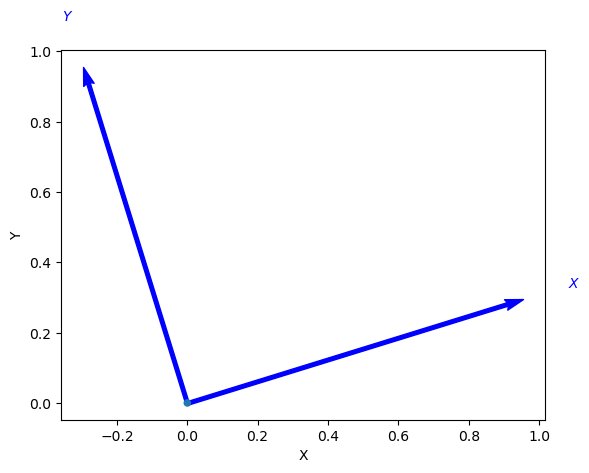

In [63]:
trplot2(R)

In [64]:
det(R)

1.00000000000000

In [65]:
det(R @ R)


1.00000000000000